Imports

In [117]:
import sklearn as sk;
import pandas as pd;
import os;
from google.colab import files;
import matplotlib.pyplot as plt
import seaborn as sns

In [118]:
from google.colab import drive
# for mounting google drive to access training data from
# filepath: /content/drive/MyDrive/Colab Notebooks
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


Data cleaning

In [119]:
def norm(attr):
    clean_churn_train[attr] = (
        (clean_churn_train[attr] - clean_churn_train[attr].mean())/clean_churn_train[attr].std()
    )
def continuous_bin(attr, bins):
    intervals = 1/bins
    percentiles = clean_churn_train[attr].quantile([i*intervals for i in range(0, bins + 1)])
    bins = list(map(lambda x : float(x), percentiles))

    clean_churn_train[attr] = pd.cut(
        clean_churn_train[attr], bins=bins,
        labels=bins[1:]
        )


In [120]:
# importing data into dataframes
not_loaded = True
while not_loaded:
    try:
        if "churn_train.csv" in os.listdir():
            churn_train = pd.read_csv("customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("customer_churn_dataset-testing-master.csv")
            not_loaded = False
        else:
            churn_train = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-training-master.csv")
            churn_test = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/customer_churn_dataset-testing-master.csv")
            not_loaded = False
    except FileNotFoundError as e:
        files.upload()

In [121]:
for attr in churn_train.columns:
    if len(churn_train[attr].unique()) < 10:
        print(f"{attr}: {churn_train[attr].value_counts()}")

Gender: Gender
Male      250252
Female    190580
Name: count, dtype: int64
Subscription Type: Subscription Type
Standard    149128
Premium     148678
Basic       143026
Name: count, dtype: int64
Contract Length: Contract Length
Annual       177198
Quarterly    176530
Monthly       87104
Name: count, dtype: int64
Churn: Churn
1.0    249999
0.0    190833
Name: count, dtype: int64


In [122]:
gender = {"Female":0, "Male":1}
Sub_type = {"Standard":0, "Basic":1, "Premium":2}
Con_len = {"Annual":0, "Quarterly":1, "Monthly":2}

# converted df
conv_churn_train = churn_train.copy()
conv_churn_train["Gender"] = conv_churn_train["Gender"].map(gender)
conv_churn_train["Subscription Type"] = conv_churn_train["Subscription Type"].map(Sub_type)
conv_churn_train["Contract Length"] = conv_churn_train["Contract Length"].map(Con_len)


In [123]:
missing = conv_churn_train.isnull().any(axis=0).sum()
total = len(churn_train.index)
# print((missing / total)*100)
# 0.002% columns are null! There are 9 records that are empty.
# Because the missing data takes up a small portion of the training data I will be employing kNNImputer as I can afford the computation overhead

imputer = sk.impute.KNNImputer(n_neighbors=2)
clean_churn_train = pd.DataFrame(imputer.fit_transform(conv_churn_train))
clean_churn_train.columns = conv_churn_train.columns
filled = clean_churn_train.isnull().any(axis=0).sum()
print(f"number of rows with nan:{missing}\nnumber of rows with nan after cleaning:{filled}")

number of rows with nan:12
number of rows with nan after cleaning:0


Pre-processing

In [124]:
norm("Last Interaction")
variance = clean_churn_train['Last Interaction'].std() ** 2
mean = clean_churn_train['Last Interaction'].mean()
print(f"var{variance:.2e}, mean{mean:.2e}\nApproximately 1 and 0")

var1.00e+00, mean1.18e-16
Approximately 1 and 0


In [125]:
# Calculate percentiles for 'Total Spend'
continuous_bin("Total Spend", 5)

In [126]:
print("Number of rows for each 'Total Spend' quantile:")
print(clean_churn_train['Total Spend'].value_counts().sort_index())

Number of rows for each 'Total Spend' quantile:
Total Spend
405.000     88248
592.778     87985
728.720     88171
863.640     88166
1000.000    88163
Name: count, dtype: int64


In [127]:
cat_encoder = sk.preprocessing.OneHotEncoder()
clean_churn_train_OneHot = cat_encoder.fit_transform(clean_churn_train[['Contract Length']])

In [128]:
# test_churn_train = clean_churn_train.copy() #COPY HERE FOR TESTING

In [129]:
# correlation_df = test_churn_train[['Churn']].copy()
# test_churn_train.columns.drop('Churn')

# for attr1 in test_churn_train.columns:
#     for attr2 in test_churn_train.columns:
#         if attr1 != attr2:
#             try:
#                 correlation_df[f"{attr1}_{attr2}"] = (
#                     test_churn_train[attr1]/test_churn_train[attr2]
#                 )
#             except Exception as e:
#                 print(f"{e}\n")

# Choosing Support call rate because support calls has the highest correlation coefficient
clean_churn_train['Support call rate'] =(
    clean_churn_train['Support Calls']/clean_churn_train['Tenure']
)


In [130]:
correlation_matrix = clean_churn_train.corr()
# display(correlation_matrix)

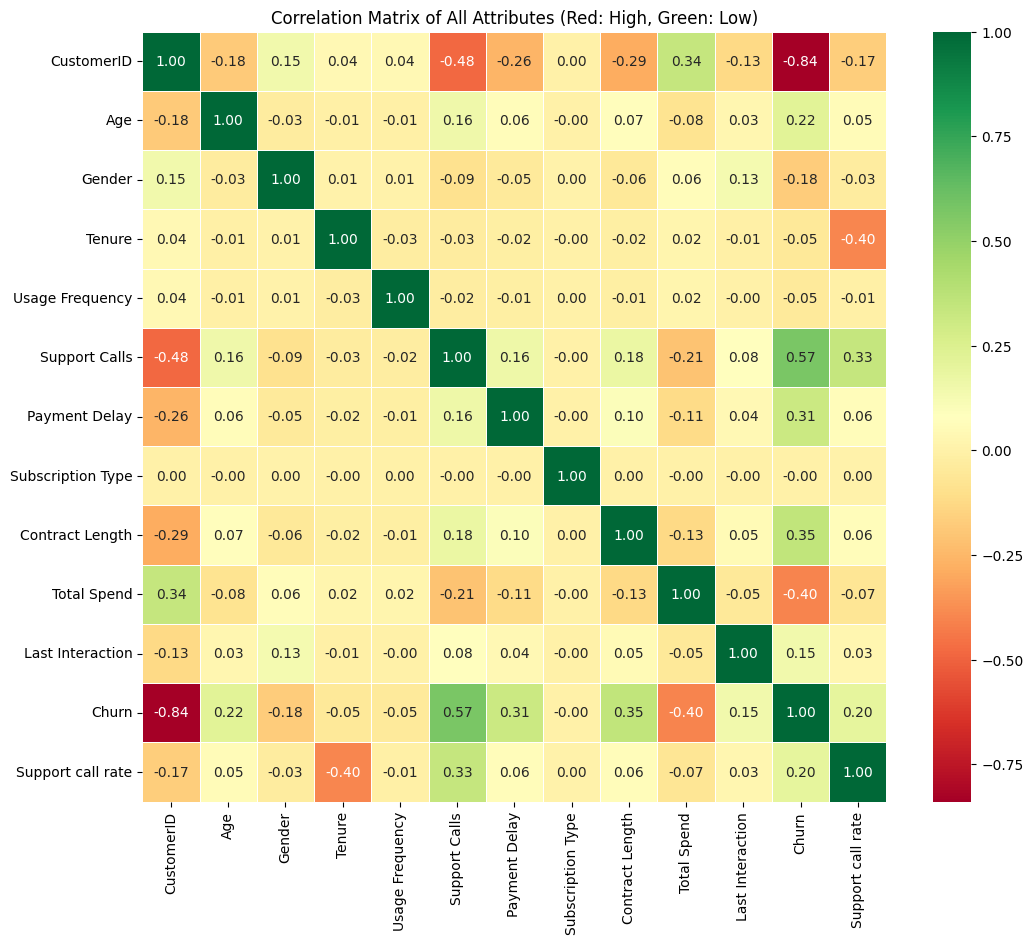

In [131]:
plt.figure(figsize=(12, 10)) # Adjust figure size for better readability
sns.heatmap(correlation_matrix, annot=True, cmap='RdYlGn', fmt=".2f", linewidths=.5)
plt.title('Correlation Matrix of All Attributes (Red: High, Green: Low)')
plt.show()

Task 2

In [132]:
#find the continuous columns
continuous_columns = []

for attr in clean_churn_train.columns:
    if len(clean_churn_train[attr].unique()) > 10:
        if attr != "CustomerID":
            continuous_columns.append(attr)
            print(f"{attr}")

Age
Tenure
Usage Frequency
Support Calls
Payment Delay
Last Interaction
Support call rate


In [132]:
for attr in continuous_columns:
    continuous_bin(attr, 10)

# Task
Implement a Decision Tree Classifier from scratch by defining a Gini impurity function, a function to find the best split, a tree node structure, a recursive tree building function, and classification functions for single samples and entire datasets. Finally, test the classifier on a subset of the `clean_churn_train` dataset.

## Define Gini Impurity Function

### Subtask:
Create a function `calculate_gini_impurity(labels)` that calculates the Gini impurity for a given array or list of class labels. This will be used to evaluate the quality of splits.


**Reasoning**:
I will define the `calculate_gini_impurity` function as described in the instructions to calculate the Gini impurity for a given set of labels.



In [133]:
import collections

def calculate_gini_impurity(labels):
    """
    Calculates the Gini impurity for a given array or list of class labels.

    Args:
        labels (list or np.array): A list or array of class labels.

    Returns:
        float: The Gini impurity of the labels.
    """
    if not labels:
        return 0.0

    # Calculate the count of each unique class label
    label_counts = collections.Counter(labels)
    total_labels = len(labels)
    gini = 1.0

    # Iterate through the counts of each unique class and calculate Gini impurity
    for count in label_counts.values():
        proportion = count / total_labels
        gini -= proportion**2

    return gini

Gini impurity for labels1: 0.6111
Gini impurity for labels2: 0.0000
Gini impurity for labels3: 0.7500
Gini impurity for labels4: 0.0000


## Define Best Split Function

### Subtask:
Create a function `find_best_split(data, feature_names)` that iterates through all features and possible split values to find the best split (feature and threshold) that minimizes the weighted Gini impurity of the child nodes. This function will consider all numerical features in the dataset.


**Reasoning**:
I need to implement the `find_best_split` function as described in the instructions. This function will iterate through features and potential thresholds, calculate weighted Gini impurity for each split, and return the best split found. I will also include an example usage with a subset of the `clean_churn_train` dataset.



In [134]:
def find_best_split(data, feature_names, target_name):
    """
    Finds the best split (feature and threshold) that minimizes the weighted Gini impurity.

    Args:
        data (pd.DataFrame): The dataset with features and target variable.
        feature_names (list): List of feature column names to consider for splitting.
        target_name (str): The name of the target column.

    Returns:
        tuple: (best_feature, best_threshold, best_gini)
    """
    best_gini = float('inf')
    best_feature = None
    best_threshold = None

    total_samples = len(data)
    if total_samples == 0:
        return best_feature, best_threshold, best_gini

    for feature in feature_names:
        # Ensure the feature is numeric before trying to find unique values for splitting
        if not pd.api.types.is_numeric_dtype(data[feature]):
            continue

        unique_values = sorted(data[feature].unique())
        thresholds = []
        if len(unique_values) > 1:
            for i in range(len(unique_values) - 1):
                thresholds.append((unique_values[i] + unique_values[i+1]) / 2)
        else:
            continue

        for threshold in thresholds:
            left_child = data[data[feature] <= threshold]
            right_child = data[data[feature] > threshold]

            if len(left_child) == 0 or len(right_child) == 0:
                continue

            gini_left = calculate_gini_impurity(left_child[target_name].tolist())
            gini_right = calculate_gini_impurity(right_child[target_name].tolist())

            weighted_gini = (
                (len(left_child) / total_samples) * gini_left +
                (len(right_child) / total_samples) * gini_right
            )

            if weighted_gini < best_gini:
                best_gini = weighted_gini
                best_feature = feature
                best_threshold = threshold

    return best_feature, best_threshold, best_gini

# Example Usage:
# Select a subset of the DataFrame for demonstration
# It's important to use a copy to avoid modifying the original DataFrame during testing
example_data = clean_churn_train[['Age', 'Tenure', 'Total Spend', 'Churn']].copy()
# Ensure 'Churn' is treated as a target variable, potentially converting to int if float
example_data['Churn'] = example_data['Churn'].astype(int)

# Define feature names and target name
feature_cols = ['Age', 'Tenure', 'Total Spend']
target_col = 'Churn'

# Find the best split
best_feat, best_thresh, min_gini = find_best_split(example_data, feature_cols, target_col)

print(f"Best Feature: {best_feat}")
print(f"Best Threshold: {best_thresh:.2f}")
print(f"Minimum Gini Impurity: {min_gini:.4f}")

# Test with another feature with fewer unique values like 'Gender' from original clean_churn_train
example_data_gender = clean_churn_train[['Gender', 'Churn']].copy()
example_data_gender['Churn'] = example_data_gender['Churn'].astype(int)
feature_cols_gender = ['Gender']
best_feat_gender, best_thresh_gender, min_gini_gender = find_best_split(example_data_gender, feature_cols_gender, target_col)

print(f"\nBest Feature (Gender): {best_feat_gender}")
print(f"Best Threshold (Gender): {best_thresh_gender}")
print(f"Minimum Gini Impurity (Gender): {min_gini_gender:.4f}")

Best Feature: Age
Best Threshold: 50.50
Minimum Gini Impurity: 0.4058

Best Feature (Gender): Gender
Best Threshold (Gender): 0.283840556039489
Minimum Gini Impurity (Gender): 0.4759


## Define Tree Node Structure

### Subtask:
Create a class `TreeNode` that will represent a node in the decision tree. Each node should store information relevant to its type (internal node or leaf node). If it's an internal node, it should store the splitting `feature`, `threshold`, and references to `left_child` and `right_child` nodes. If it's a leaf node, it should store the `predicted_class`.



**Reasoning**:
Now I will define the `TreeNode` class as described in the instructions. This class will serve as the building block for our decision tree, allowing us to store split information for internal nodes and predicted classes for leaf nodes.



In [135]:
class TreeNode:
    """
    Represents a node in the decision tree.

    Attributes:
        feature (str): The feature used for splitting at this node (for internal nodes).
        threshold (float): The threshold value for the split (for internal nodes).
        left_child (TreeNode): Reference to the left child node.
        right_child (TreeNode): Reference to the right child node.
        predicted_class (any): The class predicted by this leaf node (for leaf nodes).
    """
    def __init__(self, feature=None, threshold=None, left_child=None, right_child=None, predicted_class=None):
        self.feature = feature
        self.threshold = threshold
        self.left_child = left_child
        self.right_child = right_child
        self.predicted_class = predicted_class

    def is_leaf(self):
        """
        Checks if the node is a leaf node.

        Returns:
            bool: True if the node is a leaf node, False otherwise.
        """
        return self.predicted_class is not None

print("TreeNode class defined.")

TreeNode class defined.


## Implement Recursive Tree Building Function

### Subtask:
Create a function `build_tree(data, feature_names, target_name, max_depth, min_samples_split, current_depth=0)` that recursively builds the decision tree.

#### Instructions:
1.  Define the `build_tree` function with parameters `data`, `feature_names`, `target_name`, `max_depth` (to prevent overfitting), `min_samples_split` (minimum samples required to split a node), and `current_depth` (initial depth is 0).
2.  Implement stopping conditions:
    *   If all labels in `data[target_name]` are the same, return a leaf node with that class.
    *   If `current_depth` equals `max_depth` or the number of samples in `data` is less than `min_samples_split`, return a leaf node with the most frequent class in `data[target_name]`.
    *   If `data` is empty, return a leaf node with `None` as the predicted class.
3.  Call `find_best_split` to get the `best_feature`, `best_threshold`, and `min_gini` for the current `data`.
4.  If `min_gini` is `inf` (meaning no good split was found), return a leaf node with the most frequent class in `data[target_name]`.
5.  Split the data into `left_data` and `right_data` based on the `best_feature` and `best_threshold`.
6.  Recursively call `build_tree` for `left_data` to get `left_child`.
7.  Recursively call `build_tree` for `right_data` to get `right_child`.
8.  Return an internal `TreeNode` with the `best_feature`, `best_threshold`, `left_child`, and `right_child`.

**Reasoning**:
Now I will implement the `build_tree` function, which will recursively construct the decision tree by applying the Gini impurity calculation and best split finding logic from the previous steps. This function will also include the specified stopping conditions to prevent overfitting and handle edge cases.



In [136]:
def get_most_frequent_class(labels):
    """
    Returns the most frequent class in a list of labels.
    """
    if not labels:
        return None
    return collections.Counter(labels).most_common(1)[0][0]

def build_tree(data, feature_names, target_name, max_depth, min_samples_split, current_depth=0):
    """
    Recursively builds a decision tree.

    Args:
        data (pd.DataFrame): The current subset of the dataset.
        feature_names (list): List of feature column names.
        target_name (str): The name of the target column.
        max_depth (int): The maximum depth of the tree.
        min_samples_split (int): The minimum number of samples required to split an internal node.
        current_depth (int): The current depth of the tree (starts at 0).

    Returns:
        TreeNode: The root node of the built (sub)tree.
    """
    # Stopping condition 1: All labels are the same
    unique_labels = data[target_name].unique()
    if len(unique_labels) == 1:
        return TreeNode(predicted_class=unique_labels[0])

    # Stopping condition 2: Max depth reached or not enough samples to split
    if current_depth == max_depth or len(data) < min_samples_split:
        predicted_class = get_most_frequent_class(data[target_name].tolist())
        return TreeNode(predicted_class=predicted_class)

    # Stopping condition 3: Data is empty
    if data.empty:
        return TreeNode(predicted_class=None)

    # Find the best split
    best_feature, best_threshold, min_gini = find_best_split(data, feature_names, target_name)

    # Stopping condition 4: No good split found (e.g., all samples have same feature value)
    if best_feature is None or min_gini == float('inf'):
        predicted_class = get_most_frequent_class(data[target_name].tolist())
        return TreeNode(predicted_class=predicted_class)

    # Split the data
    left_data = data[data[best_feature] <= best_threshold]
    right_data = data[data[best_feature] > best_threshold]

    # If a split results in an empty child, make the current node a leaf
    if len(left_data) == 0 or len(right_data) == 0:
        predicted_class = get_most_frequent_class(data[target_name].tolist())
        return TreeNode(predicted_class=predicted_class)

    # Recursively build children
    left_child = build_tree(left_data, feature_names, target_name, max_depth, min_samples_split, current_depth + 1)
    right_child = build_tree(right_data, feature_names, target_name, max_depth, min_samples_split, current_depth + 1)

    return TreeNode(
        feature=best_feature,
        threshold=best_threshold,
        left_child=left_child,
        right_child=right_child
    )

print("build_tree function defined.")

build_tree function defined.


## Implement Classification Functions

### Subtask:
Create a function `predict_single_sample(tree, sample)` that traverses the decision tree to classify a single data sample.

#### Instructions:
1.  Define a function named `predict_single_sample` that takes the `tree` (the root `TreeNode` of the trained decision tree) and a `sample` (a Pandas Series or dictionary representing a single data point) as input.
2.  Implement the logic to traverse the tree:
    *   Start at the `tree` root.
    *   If the current node is a leaf (`node.is_leaf()` is True), return its `predicted_class`.
    *   If the current node is an internal node, compare the `sample`'s value for `node.feature` with `node.threshold`.
    *   Recursively call `predict_single_sample` on the `node.left_child` if `sample[node.feature] <= node.threshold`.
    *   Recursively call `predict_single_sample` on the `node.right_child` if `sample[node.feature] > node.threshold`.



**Reasoning**:
I will implement the `predict_single_sample` function, which will traverse the decision tree to predict the class for a given single data sample as described in the instructions.



In [137]:
def predict_single_sample(tree, sample):
    """
    Traverses the decision tree to classify a single data sample.

    Args:
        tree (TreeNode): The root node of the trained decision tree.
        sample (pd.Series or dict): A single data point with feature values.

    Returns:
        any: The predicted class for the sample.
    """
    node = tree
    while not node.is_leaf():
        feature_value = sample[node.feature]
        if feature_value <= node.threshold:
            node = node.left_child
        else:
            node = node.right_child
    return node.predicted_class

print("predict_single_sample function defined.")

predict_single_sample function defined.


### Subtask:
Create a function `predict_dataset(tree, data)` that applies the `predict_single_sample` function to each row of a given DataFrame, returning a list of predictions.

### Subtask:
Create a function `predict_dataset(tree, data)` that applies the `predict_single_sample` function to each row of a given DataFrame, returning a list of predictions.

**Reasoning**:
I need to implement the `predict_dataset` function as described in the instructions, which will iterate through each row of the input DataFrame and apply the `predict_single_sample` function to generate predictions.



In [138]:
def predict_dataset(tree, data):
    """
    Applies the predict_single_sample function to each row of a given DataFrame.

    Args:
        tree (TreeNode): The root node of the trained decision tree.
        data (pd.DataFrame): The DataFrame containing samples to classify.

    Returns:
        list: A list of predicted classes for each sample in the DataFrame.
    """
    predictions = []
    for _, sample in data.iterrows():
        predictions.append(predict_single_sample(tree, sample))
    return predictions

print("predict_dataset function defined.")

predict_dataset function defined.


## Test the Decision Tree Classifier

### Subtask:
Test the implemented Decision Tree Classifier on a subset of the `clean_churn_train` dataset.

#### Instructions:
1. Prepare a subset of the `clean_churn_train` dataset for training and testing. Choose relevant features and the 'Churn' column as the target.
2. Split the subset into training and testing sets (e.g., 80% train, 20% test).
3. Train the decision tree using the `build_tree` function with appropriate `max_depth` and `min_samples_split` parameters.
4. Use the `predict_dataset` function to get predictions on the test set.
5. Evaluate the performance of the classifier (e.g., by calculating accuracy).

**Reasoning**:
Now I will implement the test for the Decision Tree Classifier, following the instructions to prepare the data, split it into training and testing sets, build the tree, make predictions, and evaluate the model's accuracy. This will demonstrate the complete functionality of the custom-built Decision Tree.



In [139]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score

# 1. Prepare a subset of the clean_churn_train dataset
# Using relevant features that were processed earlier (e.g., binned, normalized)
# and 'Churn' as the target.
# Let's include 'Age', 'Tenure', 'Total Spend' (which was binned), 'Support Calls' (binned),
# 'Payment Delay' (binned), 'Usage Frequency' (binned), 'Last Interaction' (normalized)
# and original categorical features 'Gender', 'Subscription Type', 'Contract Length' (mapped to numerical).

# Make a copy to avoid modifying the original clean_churn_train DataFrame
df_model = clean_churn_train.copy()

# Convert 'Churn' to int if it's not already (it was in example usage before, but good to ensure)
df_model['Churn'] = df_model['Churn'].astype(int)

# Define features (X) and target (y)
# We will use all numerical features and the ones that were processed.
# Exclude 'CustomerID' as it's an identifier.
feature_columns = [
    'Age', 'Tenure', 'Usage Frequency', 'Support Calls', 'Payment Delay',
    'Last Interaction', 'Total Spend', 'Gender', 'Subscription Type', 'Contract Length',
    'Support call rate'
]

X = df_model[feature_columns]
y = df_model['Churn']

# 2. Split the subset into training and testing sets (e.g., 80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Combine X_train and y_train for the build_tree function
train_data = pd.concat([X_train, y_train], axis=1)
test_data = pd.concat([X_test, y_test], axis=1)

# 3. Train the decision tree using the build_tree function
max_depth = 5 # Example: limit depth to prevent deep trees and potential overfitting
min_samples_split = 10 # Example: require at least 10 samples to split a node

print("Building the Decision Tree...")
decision_tree = build_tree(
    data=train_data,
    feature_names=feature_columns,
    target_name='Churn',
    max_depth=max_depth,
    min_samples_split=min_samples_split
)
print("Decision Tree built successfully.")

# 4. Use the predict_dataset function to get predictions on the test set
print("Making predictions on the test set...")
predictions = predict_dataset(decision_tree, X_test)
print("Predictions made.")

# 5. Evaluate the performance of the classifier
accuracy = accuracy_score(y_test, predictions)

print(f"\nDecision Tree Classifier Accuracy: {accuracy:.4f}")

Building the Decision Tree...


KeyboardInterrupt: 